## Synthetic Voice Deepfakes Detection Using MFCC Features

#### 1. Intro
This notebook walks through the process of creating labeled audio data, extracting features, and training a machine learning model to distinguish between real and fake voices using MFCCs (Mel-frequency cepstral coefficients). The goal is to build a system that can accurately identify synthetic voices and provide real-time alerts.

#### 2. Setup

In [1]:
import os
import librosa, numpy as np, scipy, matplotlib, sklearn, pandas as pd
from gtts import gTTS
from pydub import AudioSegment


/opt/anaconda3/lib/python3.12/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


#### 3. Data Preparation
We define the paths for the audio files and the transcript data, then load the transcript CSV for further processing.

In [2]:
# Defining paths and loading the transcripts
notebook_dir = os.getcwd()  
ROOT_DIR = os.path.dirname(notebook_dir)
transcripts_path = os.path.join(ROOT_DIR, 'assets', 'audio', 'transcripts', 'transcripts.csv')

original_audio_path = os.path.join(ROOT_DIR, 'assets', 'audio', 'original_audio')
processed_audio_path = os.path.join(ROOT_DIR, 'assets', 'audio', 'processed_audio', 'real')

transcripts = pd.read_csv(transcripts_path)

#### 4. Generate Fake Audio Samples
Generate synthetic voices using the Google Text-to-Speech (gTTS) library based on the transcript data and save them as .wav files.

In [3]:
# Generate fake audio based on the transcripts
generated_audio_path = os.path.join(ROOT_DIR, 'assets', 'audio', 'processed_audio', 'fake')
os.makedirs(generated_audio_path, exist_ok=True)

for index, row in transcripts.iterrows():
    text = row['text']
    id = row['id']
    tts = gTTS(text=text, lang='en')
    filename = f"{id}_fake.wav"
    tts.save(os.path.join(generated_audio_path, filename))

print(f'{len(transcripts)} audio files saved in {generated_audio_path}')


58 audio files saved in /Users/I506807/Desktop/BTS/Final_Project/voiceshield_team/assets/audio/processed_audio/fake


#### 5. Labeling Audio Data

In [17]:
# Label real and fake audio files
data = []

# Real audio files
for fname in os.listdir(processed_audio_path):
    if fname.endswith('.wav'):
        data.append({"file": os.path.join(processed_audio_path, fname), "label": "real"})

# Fake audio files
for fname in os.listdir(generated_audio_path):
    if fname.endswith('.wav'):
        data.append({"file": os.path.join(generated_audio_path, fname), "label": "fake"})

labeled_data = pd.DataFrame(data)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/I506807/Desktop/BTS/Final_Project/voiceshield_team/assets/audio/processed_audio/real'

#### 6. Feature Extraction (MFCC)
We extract Mel-frequency cepstral coefficients (MFCC) from the audio files as features to train the model.

**Definition**: MFCCs represent the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency. They aim to mimic the way humans perceive sound, especially how we’re more sensitive to certain frequency ranges (like speech).

In [7]:
# Extract MFCC features for each audio file
def extract_mfcc(path, n_mfcc=13):
    y, sr = librosa.load(path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)
    return mfcc_mean

labeled_data["features"] = labeled_data["file"].apply(extract_mfcc)


#### 7. Train-Test Split

In [8]:
from sklearn.model_selection import train_test_split

X = np.stack(labeled_data["features"].values)
y = labeled_data["label"].map({"real": 0, "fake": 1}).values

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


#### 8. Model Training

In [9]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

#### 9. Model Evaluation

In [10]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


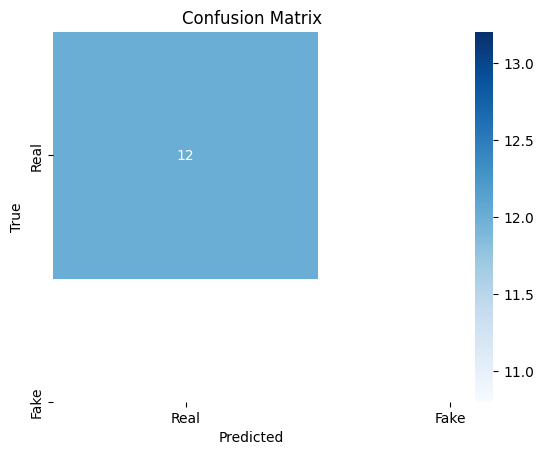

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

#### 11. PCA for Feature Visualization
Principal Component Analysis (PCA) is used to reduce the feature dimensions and visualize the data in 2D space.

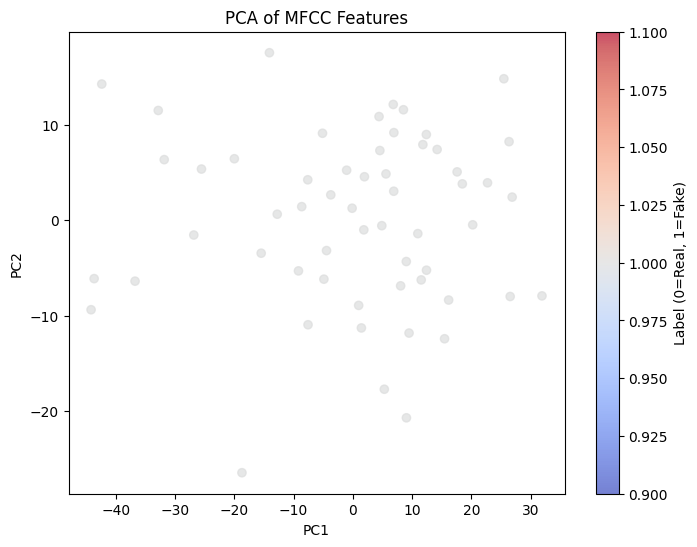

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.7)
plt.title("PCA of MFCC Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Label (0=Real, 1=Fake)')
plt.show()


#### 12. Audio Duration Analysis
We analyze the duration of the audio files to check for any significant differences between real and fake voices.

In [13]:
def get_duration(path):
    y, sr = librosa.load(path, sr=None)
    return librosa.get_duration(y=y, sr=sr)

labeled_data["duration"] = labeled_data["file"].apply(get_duration)
labeled_data.groupby("label")["duration"].describe()


,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
fake,57.0,4.784842,1.421572,2.328,3.888,4.872,5.448,10.896


#### 13. Model Retraining or Tuning

In [14]:
# Example of re-training or model tuning code (optional section for experimentation)
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=200, random_state=42)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


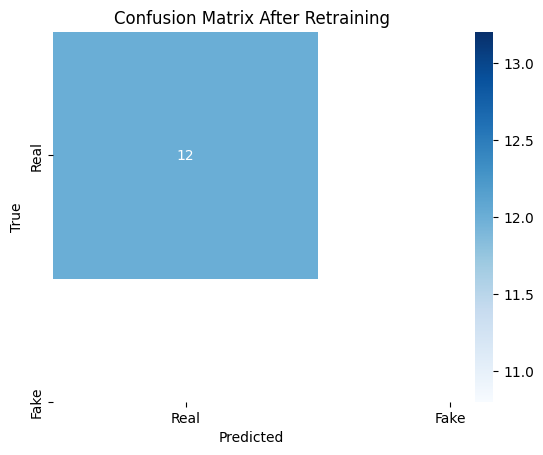

In [15]:
# Re-evaluating the model after retraining
y_pred_retrained = clf.predict(X_test)

# Printing the classification report
print(classification_report(y_test, y_pred_retrained))

# Visualizing the confusion matrix for the retrained model
cm_retrained = confusion_matrix(y_test, y_pred_retrained)

sns.heatmap(cm_retrained, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix After Retraining")
plt.show()